In [1]:
import tensorflow as tf

model = tf.keras.models.load_model("../data/models/nocall-detector")

In [26]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
from multiprocessing import Pool
from tqdm.auto import tqdm
from birdclef.utils import cens_per_sec, compute_offset

from simple_mp.simple import simple_fast

import IPython.display as ipd

In [3]:
df = pd.read_pickle("../data/cens/train_short_audio/annhum/data.pkl.gz")

In [4]:
df

,name,parent,data,sample_rate,seconds,cens,cens_sample_rate,path
0,XC109651,annhum,"[-2.4537547e-07, 2.0267792e-07, -1.3570123e-07...",22050,15.565034,"[[0.29618025941490334, 0.30020164900487106, 0....",10,data/input/train_short_audio/annhum/XC109651.ogg
1,XC109852,annhum,"[-0.000108159176, -0.0003503968, 0.00010555217...",22050,73.573016,"[[0.1868339278472008, 0.18851538461563427, 0.1...",10,data/input/train_short_audio/annhum/XC109852.ogg
2,XC120842,annhum,"[1.0977172e-08, 4.7067115e-09, 6.23323e-08, -6...",22050,105.013016,"[[0.2533065645653171, 0.25389133260386443, 0.2...",10,data/input/train_short_audio/annhum/XC120842.ogg
3,XC120843,annhum,"[-1.657217e-08, 3.8164627e-09, -3.2404717e-08,...",22050,114.085034,"[[0.27457029223556023, 0.2742263011869448, 0.2...",10,data/input/train_short_audio/annhum/XC120843.ogg
4,XC121435,annhum,"[8.9477666e-08, -1.0370462e-07, 1.5270678e-07,...",22050,24.829025,"[[0.2617586174190063, 0.2650336605620707, 0.26...",10,data/input/train_short_audio/annhum/XC121435.ogg
...,...,...,...,...,...,...,...,...
118,XC57970,annhum,"[-0.001582256, -0.002369195, -0.002061126, -0....",22050,8.895828,"[[0.2761027355796823, 0.2773745632227378, 0.27...",10,data/input/train_short_audio/annhum/XC57970.ogg
119,XC57971,annhum,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,18.299909,"[[0.28620556693480176, 0.2844311449980515, 0.2...",10,data/input/train_short_audio/annhum/XC57971.ogg
120,XC603659,annhum,"[-1.2759496e-05, -2.3381455e-05, -6.835765e-05...",22050,21.229025,"[[0.26111325684992254, 0.26167057122716675, 0....",10,data/input/train_short_audio/annhum/XC603659.ogg
121,XC610962,annhum,"[-3.6633014e-06, -4.880688e-06, -4.462042e-06,...",22050,219.445034,"[[0.2464950960047074, 0.24831056843148275, 0.2...",10,data/input/train_short_audio/annhum/XC610962.ogg


In [5]:
sample_rate = 22050
convert = partial(
    librosa.feature.chroma_cens,
    hop_length=cens_per_sec(sample_rate, 4),
    n_chroma=36,
    win_len_smooth=None,
)
n = df.shape[0]
with Pool(10) as p:
    conv = list(tqdm(p.imap(convert, df.data), total=n))

  0%|          | 0/123 [00:00<?, ?it/s]

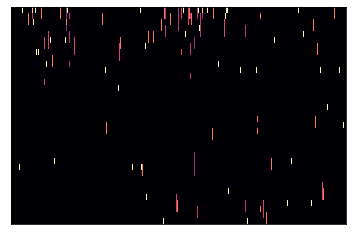

In [6]:
librosa.display.specshow(conv[2])

In [7]:
conv[1].shape

(36, 295)

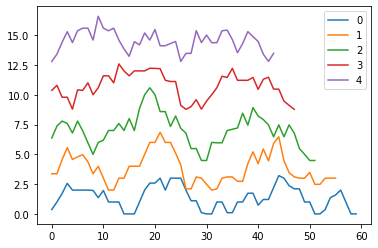

In [8]:
# 3 second window?
for i in range(5):
    mp, pi = simple_fast(conv[0], conv[0], 4*(i+1))
    plt.plot(mp, label=i)
    plt.legend()

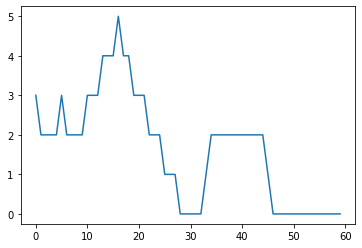

182387 246759 386233


327225 391597 386233


In [59]:
def compute_offset(index, window_size, cens_total, data_total):
    """Get the offsets into the original sampled audio by computing the relative
    percentage into the track.

    index: the index into the matrix profile
    window_size: the number of frames to keep
    cens_total: the total number of cens frames
    data_total: the total number of audio samples
    """
    start = index / (cens_total + window_size)
    end = (index + window_size) / (cens_total + window_size)
    offset = (window_size/2)/(cens_total+window_size)
    
    return int((start + offset) * data_total), int((end + offset) * data_total)

idx = 29
window = 4*3
data = df.data.iloc[idx]
mp, pi = simple_fast(conv[idx], conv[idx], window)
plt.plot(mp)
plt.show()

ipd.display(ipd.Audio(data, rate=sample_rate))
for pos in [np.argmin(mp), pi[np.argmin(mp)]]:
    s0, s1 = compute_offset(pos, window, len(mp), len(data))
    print(s0, s1, len(data))
    ipd.display(ipd.Audio(data[s0:s1], rate=sample_rate))

In [10]:
def slice_windows(data, window=4*5):
    # return 2d array of the original data
    n = data.shape[1]
    indexes = np.array(
        [np.arange(i, i+window) for i in range(0, n, window//5) if i + window < n]
    )
    return np.transpose(data[:, indexes], [1, 0, 2])

In [11]:
X = slice_windows(conv[idx])
X.shape

(69, 36, 20)

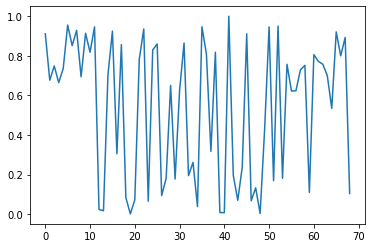

In [12]:
res = model.predict(X.reshape(X.shape[0], -1)).T[0]
plt.plot(res)

In [14]:
res

array([0.91025007, 0.67635155, 0.74804896, 0.6639535 , 0.7347994 ,
       0.95458233, 0.85072875, 0.92765206, 0.69340575, 0.9127576 ,
       0.81737286, 0.94536424, 0.02351141, 0.01725598, 0.7038537 ,
       0.92390424, 0.304664  , 0.85631645, 0.08393154, 0.00118243,
       0.07226983, 0.78271484, 0.9348973 , 0.06520923, 0.8285829 ,
       0.85896766, 0.09379171, 0.18120179, 0.6496647 , 0.17748185,
       0.6231633 , 0.86389226, 0.1943374 , 0.26131946, 0.03861199,
       0.9459833 , 0.8075569 , 0.31698453, 0.8175565 , 0.00810787,
       0.00754443, 0.99898165, 0.19587125, 0.06988747, 0.23645188,
       0.9104194 , 0.06751028, 0.13281363, 0.00320503, 0.426537  ,
       0.94521606, 0.1689831 , 0.94943845, 0.18074259, 0.7564073 ,
       0.62132186, 0.6231633 , 0.72808623, 0.75130093, 0.10983896,
       0.80504227, 0.771118  , 0.75681204, 0.6996243 , 0.53394693,
       0.91993713, 0.79914457, 0.8920233 , 0.10417454], dtype=float32)

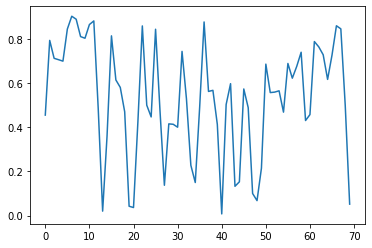

In [24]:
plt.plot(np.convolve(res, np.ones(2)/2))